## Introduction

LISA Analysis Tools is a group of code packages that brings together many different aspects of LISA data analysis. In this tutorial, we will describe the functionality of the main high-level package: `lisatools`. This includes defining sensitivity, orbit, and other information. Also, this includes computing many basic waveform-level diagnostics. 

The documentation for `lisatools` can be found [here](https://mikekatz04.github.io/LISAanalysistools).

If you use this code, please cite the [zenodo](https://zenodo.org/records/10930980). 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from eryn.utils import TransformContainer

from lisatools.sensitivity import *
from lisatools.utils.constants import *
from lisatools.diagnostic import *
from lisatools.detector import EqualArmlengthOrbits, ESAOrbits
from lisatools.detector import LISAModel
from lisatools.detector import get_available_default_lisa_models
from lisatools.detector import scirdv1


## LISA Sensitivity

We will begin with generating the LISA sensitivity. You can do this with the `lisatools.sensitivity.get_sensitivity` function. Some helpful keyword arguments:
* `sens_fn`: Type of sensitivity response function. Base sensitivity or TDI sensitivity. Base sensitivity: `LISASens`. TDI sensitivities are shown below.
* return_type: PSD, ASD, or characteristic strain.

Text(0, 0.5, 'Characteristic Strain')

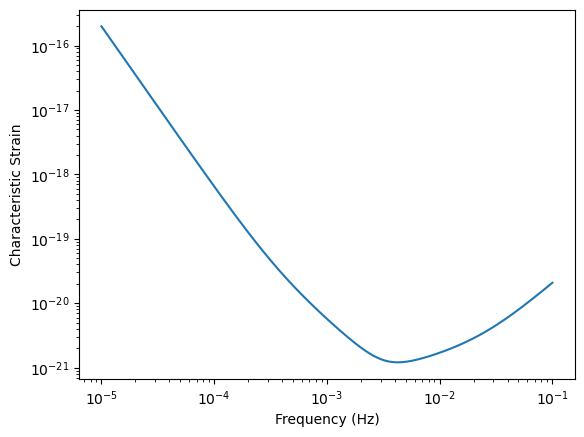

In [2]:
f = np.logspace(-5, -1, 10000)
Sn = get_sensitivity(f, sens_fn=LISASens, return_type="char_strain")
plt.loglog(f, Sn)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")

Stock sensitivity options can be found with `lisatools.sensitivity.get_stock_sensitivity_options`.

In [3]:
from lisatools.sensitivity import get_stock_sensitivity_options

In [4]:
get_stock_sensitivity_options()

['X1TDISens',
 'Y1TDISens',
 'Z1TDISens',
 'XY1TDISens',
 'YZ1TDISens',
 'ZX1TDISens',
 'A1TDISens',
 'E1TDISens',
 'T1TDISens',
 'X2TDISens',
 'Y2TDISens',
 'Z2TDISens',
 'LISASens',
 'CornishLISASens',
 'FlatPSDFunction']

### PSD for TDI channels X,Y,Z

Plot the TDI X,Y,Z channels (`X1TDISens`, `Y1TDISens`, `Z1TDISens`) and cross-sensitivity (`XY1TDISens`, `YZ1TDISens`, `ZX1TDISens`). The "1" here represents TDI generation 1. TDI 2 is available, but not the cross-terms yet. They need to be added. 

Text(0, 0.5, 'PSD')

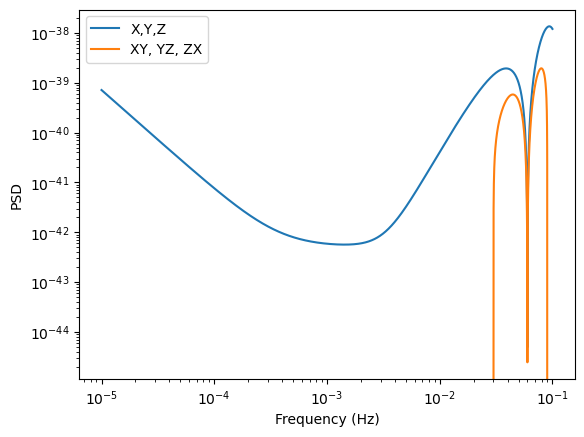

In [5]:
f = np.logspace(-5, -1, 10000)
Sn = get_sensitivity(f, sens_fn=X1TDISens, return_type="PSD")
plt.loglog(f, Sn, label="X,Y,Z")
Cn = get_sensitivity(f, sens_fn=XY1TDISens, return_type="PSD")
plt.loglog(f, Cn, label="XY, YZ, ZX")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")

### PSD for TDI channels A,E,T

Similary now for TDI A,E,T channels.

Text(0, 0.5, 'PSD')

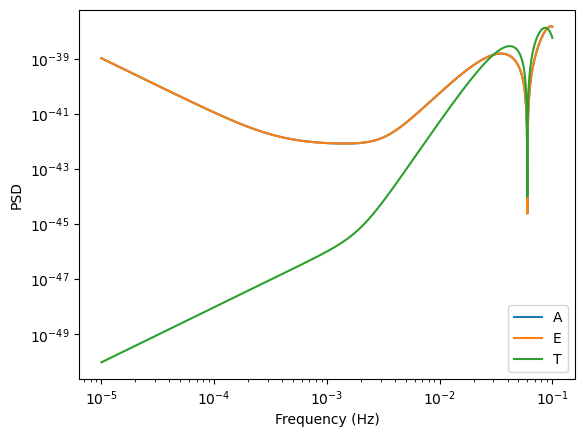

In [6]:
f = np.logspace(-5, -1, 10000)
SnA = get_sensitivity(f, sens_fn=A1TDISens, return_type="PSD")
SnE = get_sensitivity(f, sens_fn=E1TDISens, return_type="PSD")
SnT = get_sensitivity(f, sens_fn=T1TDISens, return_type="PSD")
plt.loglog(f, SnA, label="A")
plt.loglog(f, SnE, label="E")
plt.loglog(f, SnT, label="T")
plt.xlabel("Frequency (Hz)")
plt.legend()
plt.ylabel("PSD")

### Sensitivity Matrices

Sensitivity Matrices create a holder for sensitivity information across different channels. It allows for a common backend to be fed to diagnostic functions regardless if you are using AET in a length 3 array, XYZ in 3x3 matrix, or a set of basic `LISASens` objects. Sensitivity matrices can plot your sensitivity and update information on the fly (like if the frequency changes). 

Here is a custom version of a 3x3 sensitivity matrix. 

In [7]:
sens_mat = SensitivityMatrix(
    f,
    [
        [X1TDISens, XY1TDISens, ZX1TDISens],
        [XY1TDISens, Y1TDISens, YZ1TDISens],
        [ZX1TDISens, YZ1TDISens, Z1TDISens],
    ],
    stochastic_params=(1.0 * YRSID_SI,),
    model=lisa_models.scirdv1,
)


You can see the stock SensitivityMatrix options with `lisatools.sensitivity.get_stock_sensitivity_matrix_options`.

In [8]:
from lisatools.sensitivity import get_stock_sensitivity_matrix_options

In [9]:
get_stock_sensitivity_matrix_options()

['XYZ1SensitivityMatrix', 'AET1SensitivityMatrix', 'AE1SensitivityMatrix']

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

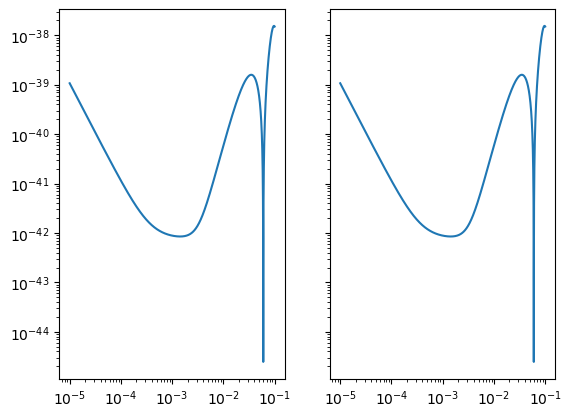

In [10]:
sens_mat2 = AE1SensitivityMatrix(
    f,
    # stochastic_params=None, (1.0 * YRSID_SI,),
    model=lisa_models.scirdv1,
)

sens_mat2.loglog()

You can adjust the frequencies, model, or stochastic information (see below for Stochastic) with the methods that start with "update." For the frequency:

In [11]:
sens_mat2.update_frequency_arr(np.logspace(-4, -1, 1000))

In [12]:
sens_mat2.frequency_arr

array([0.0001    , 0.00010069, 0.00010139, 0.0001021 , 0.0001028 ,
       0.00010352, 0.00010424, 0.00010496, 0.00010569, 0.00010642,
       0.00010716, 0.0001079 , 0.00010865, 0.00010941, 0.00011016,
       0.00011093, 0.0001117 , 0.00011247, 0.00011325, 0.00011404,
       0.00011483, 0.00011563, 0.00011643, 0.00011724, 0.00011805,
       0.00011887, 0.0001197 , 0.00012053, 0.00012136, 0.0001222 ,
       0.00012305, 0.00012391, 0.00012477, 0.00012563, 0.0001265 ,
       0.00012738, 0.00012826, 0.00012915, 0.00013005, 0.00013095,
       0.00013186, 0.00013278, 0.0001337 , 0.00013463, 0.00013556,
       0.0001365 , 0.00013745, 0.0001384 , 0.00013936, 0.00014033,
       0.0001413 , 0.00014228, 0.00014327, 0.00014426, 0.00014527,
       0.00014627, 0.00014729, 0.00014831, 0.00014934, 0.00015038,
       0.00015142, 0.00015247, 0.00015353, 0.00015459, 0.00015567,
       0.00015675, 0.00015783, 0.00015893, 0.00016003, 0.00016114,
       0.00016226, 0.00016339, 0.00016452, 0.00016566, 0.00016

## Orbits

Orbital information is read in from files and stored in an `Orbits` class. There are two stock options: `EqualArmlengthOrbits` and `ESAOrbits`. The files for the classes are directly from the LISAOrbits code. The `lisatools` `Orbits` class can take any file that is output from the LISAOrbits code.

Each orbit class, after instantiation, must be configured. This transforms the input file values into the setup used for analysis. During configuration, you can pass a time array, timestep, or you can ask the orbit class to setup for linear interpolation by passing `linear_interp_setup=True`. This setup will add enough points to the time array to make linear interpolation accurate enough. 

In [13]:
equal = EqualArmlengthOrbits()
equal.configure(linear_interp_setup=True)

esa = ESAOrbits()
esa.configure(linear_interp_setup=True)


You can access various information on the orbits with the methods that begin with `get`. 
You can get light travel times, spacecraft positions, or link normal vectors. These functions require a linear interpolation setup. 

### Link light travel times.

Text(0.5, 0, 'Time (s)')

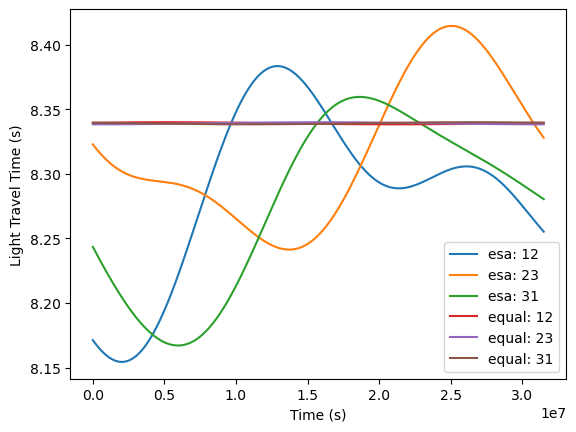

In [14]:
t_vals = np.linspace(0.0, np.min([esa.t_base.max(), equal.t_base.max()]), 1000)
for orbits, name in zip([esa, equal], ["esa", "equal"]):
    for link in [12, 23, 31]:
        plt.plot(t_vals, orbits.get_light_travel_times(t_vals, link), label=f"{name}: {link}")
plt.legend()
plt.ylabel("Light Travel Time (s)")
plt.xlabel("Time (s)")

### Spacecraft positions

Text(0.5, 0, 'Time (s)')

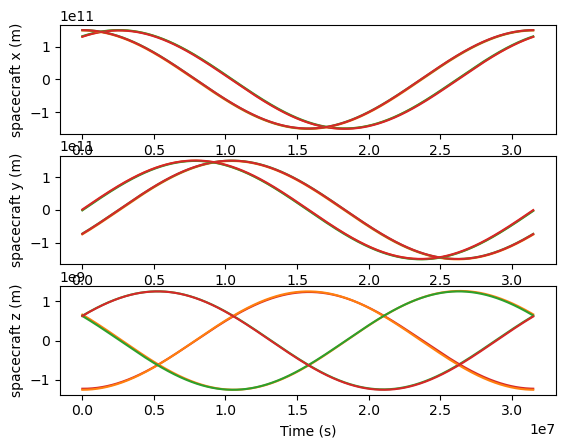

In [15]:
t_vals = np.linspace(0.0, np.min([esa.t_base.max(), equal.t_base.max()]), 1000)
fig, ax = plt.subplots(3, 1)
for orbits, name in zip([esa, equal], ["esa", "equal"]):
    for sc in [1, 2, 3]:
        pos = orbits.get_pos(t_vals, sc)
        for i in range(3):
            ax[i].plot(t_vals, pos[:, i], color=f"C{sc}", label=f"{name}: {link}")
ax[0].set_ylabel("spacecraft x (m)")
ax[1].set_ylabel("spacecraft y (m)")
ax[2].set_ylabel("spacecraft z (m)")
ax[2].set_xlabel("Time (s)")

## Defining a `LISAModel`

A `LISAModel` is a combination of sensitivity information and orbits. For the sensitivity, we define a two parameter model based on the OMS noise and acceleration noise.

In [16]:
oms_noise_term = (13.0e-12) ** 2
acceleration_noise_term = (2.0e-15) ** 2
new_lisa = LISAModel(oms_noise_term, acceleration_noise_term, equal, "new_lisa")

In [17]:
# example stock model
get_available_default_lisa_models()

[LISAModel(Soms_d=2.25e-22, Sa_a=9e-30, orbits=<lisatools.detector.DefaultOrbits object at 0x10cc20770>, name='scirdv1'),
 LISAModel(Soms_d=9.999999999999999e-23, Sa_a=9e-30, orbits=<lisatools.detector.DefaultOrbits object at 0x10a6ac980>, name='proposal'),
 LISAModel(Soms_d=9.999999999999999e-23, Sa_a=5.76e-30, orbits=<lisatools.detector.DefaultOrbits object at 0x10b091220>, name='mrdv1'),
 LISAModel(Soms_d=9.999999999999999e-23, Sa_a=5.76e-30, orbits=<lisatools.detector.DefaultOrbits object at 0x10cc68c80>, name='sangria')]

Compare two models. 

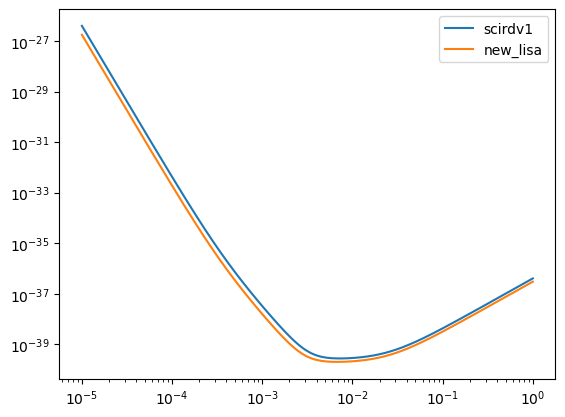

In [18]:
f = np.logspace(-5, 0, 10000)

for model in [scirdv1, new_lisa]:
    Sn = get_sensitivity(f, sens_fn="LISASens", model=model)
    plt.loglog(f, Sn, label=model.name)
plt.legend()

## Diagnostics

LISA Analysis Tools comes with a wide variety of diagnostic computations. These can be used in actual pipelines. However, they are slower, so these should mainly be used to check faster Likelihood methods. 

To begin, we will define a basic sine wave as our waveform. 

In [19]:
def sine_waveform(A, f0, phi0, t_arr):
    return A * np.sin(2 * np.pi * f0 * t_arr + phi0)

### Inner Product

You can take the inner product between to waveforms. See the inner product documentation for keyword arguments and details. 

/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:84: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:86: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:88: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:93: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:95: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0

Inner product <h1|h2>: 1547.7527441125978
Complex inner product <h1|h2>: (1547.7527441125978+313.7457311965933j), phase maximized value: 1579.2323897236156
Normalized inner product <h1|h2>: 0.9800664530641675


(1e-05, 0.10206431774793984)

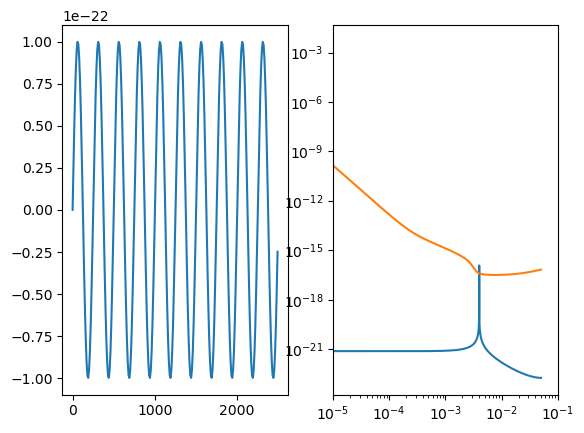

In [20]:
# create some fake signals first

A = 1e-22
f0 = 4e-3
phi0 = 0.2

dt = 10.0
t_arr = np.arange(0.0, YRSID_SI, dt)
df = 1 / (len(t_arr) * dt)
h1 = sine_waveform(A, f0, 0.0, t_arr)
h2 = sine_waveform(A, f0, phi0, t_arr)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(t_arr[:250], h1[:250])

freqs = np.fft.rfftfreq(len(h1), dt)
ax2.loglog(freqs, np.abs(np.fft.rfft(h1)))

ax2.loglog(freqs, (get_sensitivity(freqs, sens_fn="LISASens", model="sangria", stochastic_params=(YRSID_SI,)) / (4 * df)) ** (1/2))

val = inner_product(h1, h2, dt=dt, psd="LISASens", psd_kwargs=dict(model="sangria", stochastic_params=(YRSID_SI,)))
print(f"Inner product <h1|h2>: {val}")

complex_val = inner_product(h1, h2, dt=dt, psd="LISASens", psd_kwargs=dict(model="sangria", stochastic_params=(YRSID_SI,)), complex=True)
print(f"Complex inner product <h1|h2>: {complex_val}, phase maximized value: {np.abs(complex_val)}")

normalized_val = inner_product(h1, h2, dt=dt, psd="LISASens", psd_kwargs=dict(model="sangria", stochastic_params=(YRSID_SI,)), normalize=True)
print(f"Normalized inner product <h1|h2>: {normalized_val}")

ax2.set_xlim(1e-5,)

### SNR

In [21]:
opt_snr = snr(h1, dt=dt, psd="LISASens", psd_kwargs=dict(model="sangria", stochastic_params=(YRSID_SI,)))
print(f"Optimal SNR <h1|h1>^(1/2): {opt_snr}")

det_snr = snr(h1, data=h2, dt=dt, psd="LISASens", psd_kwargs=dict(model="sangria", stochastic_params=(YRSID_SI,)))
print(f"Detected SNR against data h1 <h1|h2> / <h1|h1>^(1/2): {det_snr}")

Optimal SNR <h1|h1>^(1/2): 39.73954960305257
Detected SNR against data h1 <h1|h2> / <h1|h1>^(1/2): 38.94741534749825


### Perturbed Waveform

Get a waveform with a small perturbation to a parameter.

In [22]:
# set quantities for below calculations
params = np.array([np.log(A), f0 * 1e3, phi0])
eps = 1e-9
index = 1

parameter_transforms = {
    0: np.exp,
    1: lambda x: x / 1e3
}

transform_fn = TransformContainer(parameter_transforms=parameter_transforms)


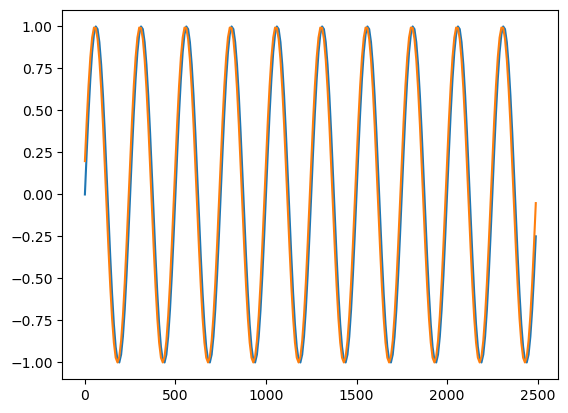

In [23]:
params = np.array([np.log(A), f0 * 1e3, phi0])
step = 1e-9
index = 1

parameter_transforms = {
    0: np.exp,
    1: lambda x: x / 1e3
}

transform_fn = TransformContainer(parameter_transforms=parameter_transforms)

# will return 2D
dh = h_var_p_eps(
    step,
    sine_waveform,
    params,
    index,
    waveform_args=(t_arr,),
    parameter_transforms=transform_fn
)

# TODO: check this?
plt.plot(t_arr[:250], h1[:250] / np.abs(h1[:250]).max())
plt.plot(t_arr[:250], dh[0, :250] / np.abs(dh[0, :250]).max())

### Derivative of Waveform

Compute the derivative of a waveform with respect to a parameter.

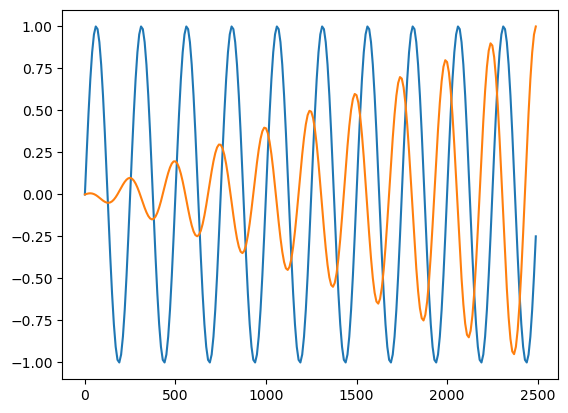

In [24]:
dhdlam = dh_dlambda(
    eps,
    sine_waveform,
    params,
    index,
    waveform_args=(t_arr,),
    parameter_transforms=transform_fn
)

# TODO: check this?
plt.plot(t_arr[:250], h1[:250] / np.abs(h1[:250]).max())
plt.plot(t_arr[:250], dhdlam[0, :250] / np.abs(dhdlam[0, :250]).max())

### Information Matrix and Covariance

Information matrix and covariance matrices. 

In [25]:
params = np.array([np.log(A), f0 * 1e3, phi0])
eps = 1e-9

info_mat_args = (eps, sine_waveform, params)
info_mat_kwargs = dict(
    deriv_inds=None,
    inner_product_kwargs={
        "psd": "LISASens",
        "psd_kwargs": dict(model="sangria", stochastic_params=(YRSID_SI,)),
        "dt": dt,
    },
    return_derivs=False,
    waveform_args=(t_arr,),
    parameter_transforms=transform_fn,
)
im = info_matrix(*info_mat_args, **info_mat_kwargs)

cov = covariance(
    *info_mat_args,
    info_mat=None,
    diagonalize=False,
    return_info_mat=False,
    precision=True,
    **info_mat_kwargs,
)
print(cov)

[[ 6.33224578e-04 -1.43715072e-13  1.26845076e-08]
 [-1.43715072e-13  1.87102133e-13 -1.86393910e-08]
 [ 1.26845076e-08 -1.86393910e-08  2.50332470e-03]]


Visualizing your information matrix.

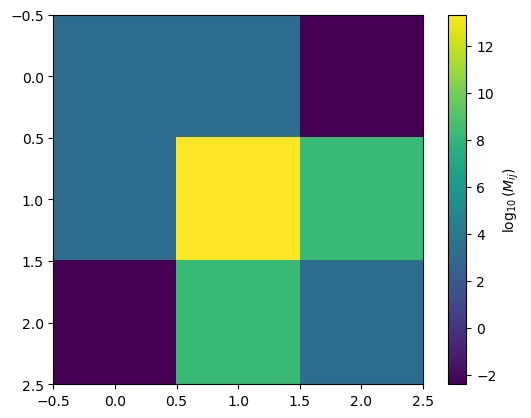

In [26]:
plt.imshow(np.log10(im))
plt.colorbar(label=r"$\log_{10}(M_{ij})$")

### Plot Covariance in Corner Plot

You can plot a corner plot by generated samples from the covariance matrix.s

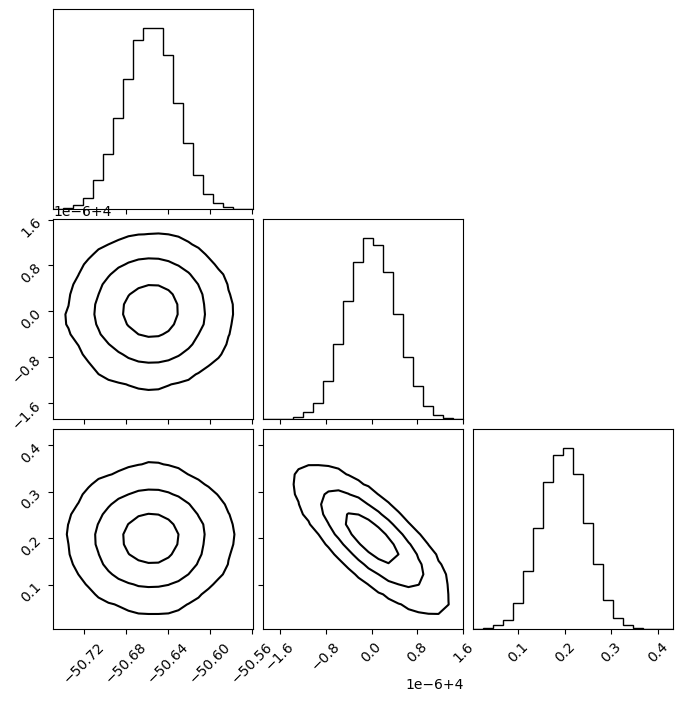

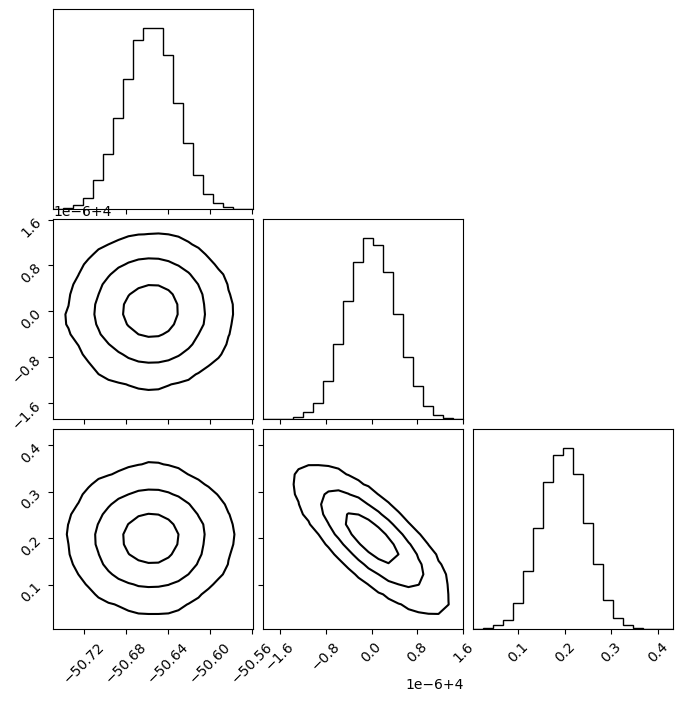

In [27]:
plot_kwargs = dict(
    plot_density=False,
    plot_datapoints=False,  # fake in this case
    smooth=0.8,
    levels=1 - np.exp(-0.5 * np.array([1, 2, 3]) ** 2)  # 1, 2, 3 sigma
)

plot_covariance_corner(
    params,
    cov,
    **plot_kwargs
)

Make a single contour plot.

<Axes: >

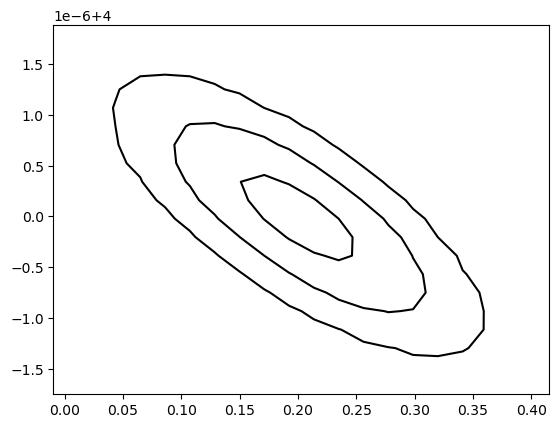

In [28]:
fig, ax = plt.subplots(1,1)

plot_covariance_contour(
    params,
    cov,
    2,
    1,
    ax=ax,
    **plot_kwargs
)

### Get Eigeninfo of a matrix (high-precision capability)

Get eigenvectors and eigenvalues of a matrix with high-precision capability. 

In [29]:
evals, evecs = get_eigeninfo(
    cov, high_precision=False
)
evals, evecs

(array([6.33224578e-04, 2.50332470e-03, 4.83159431e-14]),
 array([[ 1.00000000e+00,  6.78279596e-06,  7.78050608e-11],
        [-2.73013503e-11, -7.44585431e-06,  1.00000000e+00],
        [-6.78279596e-06,  1.00000000e+00,  7.44585431e-06]]))

### Scale to a given SNR

Scaled an injection signal to a given SNR in place.

In [30]:
target_snr = 30.0
h1 = sine_waveform(A, f0, 0.0, t_arr)

h1_scaled = scale_to_snr(
    target_snr,
    h1,
    dt=dt, 
    psd="LISASens", 
    psd_kwargs=dict(model="sangria", stochastic_params=(YRSID_SI,))
)

print(h1 / h1_scaled)

/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:84: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:86: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:88: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:93: RuntimeWarning: divide by zero encountered in divide
  Soms_

[       nan 1.32465165 1.32465165 ... 1.32465165 1.32465165 1.32465165]


/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/stochastic.py:178: RuntimeWarning: divide by zero encountered in power
  * (f ** (-7.0 / 3.0))
/var/folders/j0/bh276m5s531565_7zdy_t5m40000gp/T/ipykernel_44643/752658551.py:12: RuntimeWarning: invalid value encountered in divide
  print(h1 / h1_scaled)


### Bias estimate

Approximate waveform with a purposeful bias on the amplitude. Use the C-V bias estimate using our underlying covariance methods.

In [31]:
def sine_waveform_approx(A, f0, phi0, t_arr):
    return A * 1.03 * np.sin(2 * np.pi * (f0 * 0.98) * t_arr + phi0)


In [32]:
sys_err, bias = cutler_vallisneri_bias(
    sine_waveform,
    sine_waveform_approx,
    params,
    eps,
    parameter_transforms=transform_fn,
    inner_product_kwargs={
        "psd": "LISASens",
        "psd_kwargs": dict(model="sangria", stochastic_params=(YRSID_SI,)),
        "dt": dt,
    },
    waveform_true_args=(t_arr,),
    waveform_approx_args=(t_arr,),
)
print(sys_err, bias)

[1.57930342e+03 1.23639291e+04 1.54004854e-01] [ 1.00005374e+00 -7.84208887e-10  1.75100732e-04]


## Data / Residual / Signal Container

This container is a holder for data, residuals, or templates. These communicate with other classes like the Sensitivity Matrix to streamline different analyses. 

In [33]:
from lisatools.datacontainer import DataResidualArray

In [34]:
arr1 = sine_waveform(A, f0, phi0, t_arr)
arr2 = sine_waveform(A, f0, phi0 + np.pi / 2, t_arr)

data = DataResidualArray([arr1, arr2], dt=dt)

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

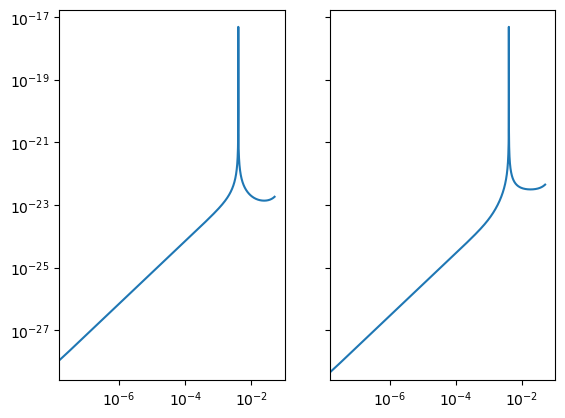

In [35]:
data.loglog(char_strain=True)

## Analysis Container

The `AnalysisContainer` brings together the `SensitivityMatrix` and the `DataResidualArray` to perform a variety of computations. 

In [36]:
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.sensitivity import LISASens

sens_mat = SensitivityMatrix(data.f_arr, [LISASens, LISASens], stochastic_params=(YRSID_SI,))
analysis = AnalysisContainer(data, sens_mat)

/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:701: RuntimeWarning: invalid value encountered in multiply
  plot_in = np.sqrt(self.frequency_arr * plot_in)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

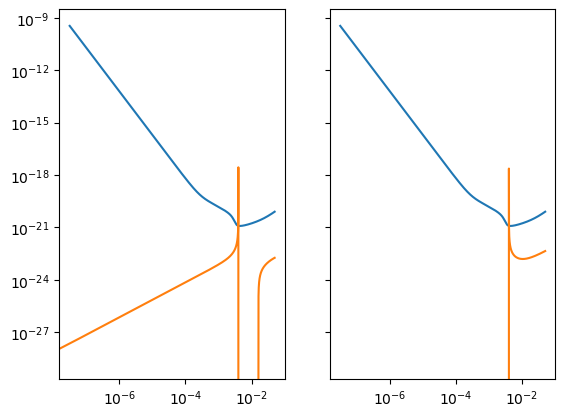

In [37]:
analysis.loglog()

### Direct computations on the residual contained in the `DataResidualArrray`.

In [38]:
analysis.inner_product()

1646.1603122108788

In [39]:
analysis.likelihood()

142084780.59000048

In [40]:
analysis.likelihood(source_only=True)

-823.0801561054394

In [41]:
analysis.likelihood(noise_only=True)

142085603.6701566

In [42]:
analysis.snr()    

40.57290120524879

### Build a template and then compare it to the data.

In [43]:
# build template
h_test = DataResidualArray([
    sine_waveform(A * 1.05, f0, phi0 + 0.002, t_arr),
    sine_waveform(A * 1.05, f0, phi0 + 0.002 + np.pi / 2., t_arr)
] , dt=dt)

print(f"Template Inner product: {analysis.template_inner_product(h_test)}") # , analysis.template_likelihood, analysis.template_snr
print(f"Template SNR: {analysis.template_snr(h_test)}") # , analysis.template_likelihood, analysis.template_snr
print(f"Template Likelihood: {analysis.template_likelihood(h_test)}") # , analysis.template_likelihood, analysis.template_snr

Template Inner product: 1728.4648708859095
Template SNR: (42.60154626551122, 40.572820059473216)
Template Likelihood: -2.061157325776094


### Build a template generation model and add to the `AnalysisContainer`

This allows for inputing parameters and waveform settings directly to the `AnalysisContainer` for computations.

In [44]:
def signal_model_sine(A, f0, phi0, t_arr):
    template = DataResidualArray([
        sine_waveform(A, f0, phi0, t_arr),
        sine_waveform(A, f0, phi0 + np.pi / 2., t_arr)
    ] , dt=dt)
    return template

analysis.signal_gen = signal_model_sine

In [45]:
print(f"With parameters likelihood: {analysis.calculate_signal_likelihood(A, f0, phi0, t_arr, source_only=True)}")
print(f"With parameters snr: {analysis.calculate_signal_snr(A, f0, phi0, t_arr)}")
print(f"With parameters inner product: {analysis.calculate_signal_inner_product(A, f0, phi0, t_arr)}")

With parameters likelihood: 2.2737367544323206e-13
With parameters snr: (40.57290120524879, 40.5729012052488)
With parameters inner product: 1646.1603122108788
